In [12]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

In [13]:
BATCH_SIZE = 25
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=20

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Gender",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 100 files belonging to 2 classes.


In [15]:
class_name = dataset.class_names
class_name

['Male', 'female']

In [16]:
len(dataset)

4

In [17]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(224, 224, 3)


In [18]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(25, 224, 224, 3)
[0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0]


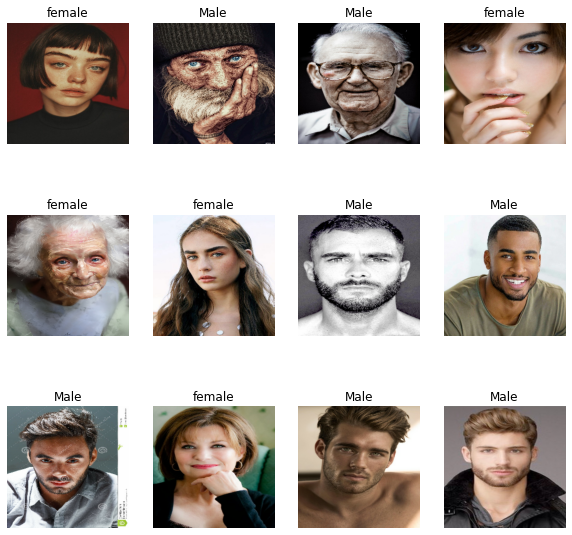

In [19]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.3, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

2

In [23]:
len(test_ds)

1

In [24]:
len(val_ds)

1

In [25]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (25, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (25, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (25, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (25, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (25, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (25, 52, 52, 64)         

In [29]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
2/2 [==============================] - 10s 5s/step - loss: 0.9041 - accuracy: 0.4400 - val_loss: 0.7644 - val_accuracy: 0.5200
Epoch 2/20
2/2 [==============================] - 7s 4s/step - loss: 0.7502 - accuracy: 0.5200 - val_loss: 0.6918 - val_accuracy: 0.5200
Epoch 3/20
2/2 [==============================] - 8s 4s/step - loss: 0.6733 - accuracy: 0.5800 - val_loss: 0.6729 - val_accuracy: 0.5200
Epoch 4/20
2/2 [==============================] - 8s 4s/step - loss: 0.6594 - accuracy: 0.5800 - val_loss: 0.6145 - val_accuracy: 0.7600
Epoch 5/20
2/2 [==============================] - 8s 4s/step - loss: 0.6548 - accuracy: 0.6600 - val_loss: 0.6850 - val_accuracy: 0.4400
Epoch 6/20
2/2 [==============================] - 7s 4s/step - loss: 0.6671 - accuracy: 0.5400 - val_loss: 0.5741 - val_accuracy: 0.8000
Epoch 7/20
2/2 [==============================] - 8s 4s/step - loss: 0.5740 - accuracy: 0.7200 - val_loss: 0.5119 - val_accuracy: 0.8800
Epoch 8/20
2/2 [========================

In [31]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.0131 - accuracy: 1.0000


first image to predict
actual label: Male
predicted label: Male


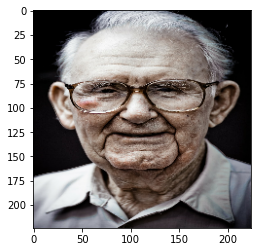

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

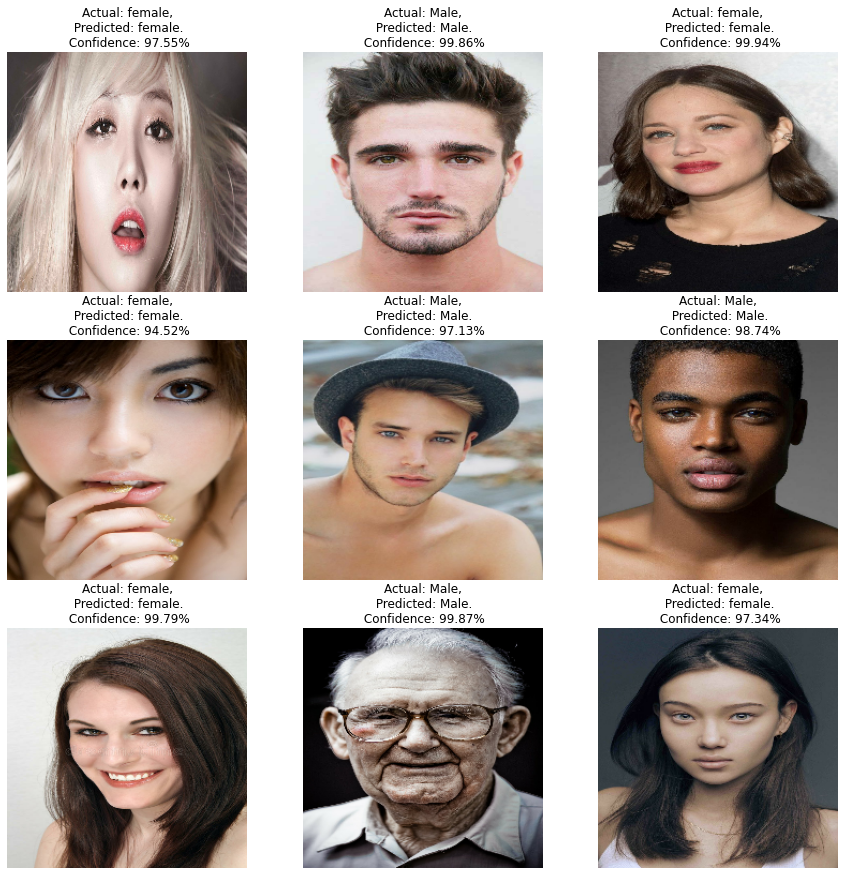

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")